In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='ticks')
import matplotlib.pyplot as plt
import seaborn as sns

import cPickle as pkl

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter

import sys
sys.path.insert(0, '../../induction_analysis')

import Analysis.induction_analysis as ia
import Analysis.sce_analysis as sce
from Analysis import filters

from lab_repo.classes.dbclasses import dbExperiment, dbMouse
from lab_repo.classes.place_cell_classes import pcExperimentGroup

from Experiments import LEDExperiment

import lab_repo.analysis.place_cell_analysis as pca
import lab_repo.analysis.behavior_analysis as ba
import lab_repo.analysis.identify_place_fields_spikes as idf

import pandas as pd

from matplotlib.gridspec import GridSpec

from scipy.stats import ttest_1samp, pearsonr, sem

/home/sebi/code/analysis/analysis-scripts/induction_analysis/Analysis/induction_analysis.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/sebi/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sebi/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sebi/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.

In [3]:
ind_experiments = [24596, 24761, 24786, 24801, 25079, 25080, 25081]
grp = [LEDExperiment.LEDExperiment(x) for x in ind_experiments]

pc_kwargs = {'imaging_label': 'soma',
               'nPositionBins': 100,
               'channel': 'Ch2',
               'demixed': False,
               'pf_subset': None,
               'signal': 'spikes'}

grp = pcExperimentGroup(grp, label='sce', **pc_kwargs)

In [4]:
def clean(ax, full=False, offset=0):
    if full:
        sns.despine(ax=ax, left=True, bottom=True, offset=offset)
        ax.set_yticks([])
        ax.set_xticks([])
    else:
        sns.despine(ax=ax, offset=offset)

In [66]:
from matplotlib import rc
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['boxplot.boxprops.linewidth'] = 1

rc('font',**{'family':'sans-serif','sans-serif':['helvetica', 'sans-serif']})
plt.rcParams['axes.unicode_minus'] = False

# Load Saved Data

In [39]:
data_dir = '/home/sebi/data/induction/fig1/'
activity_centroid_df = pd.read_pickle(data_dir + 'activity_centroid_df.pkl')
with open(data_dir + 'heatmaps.pkl', 'rb') as fp:
    avg_heatmap, heatmaps, coms = pkl.load(fp)
vel_width = pd.read_pickle(data_dir + 'vel_width.pkl')
with open(data_dir + 'tcs.pkl', 'rb') as fp:
    tcs = pkl.load(fp)
left_shifts = pd.read_pickle(data_dir + 'left_shifts.pkl')
pct_success = pd.read_pickle(data_dir + 'pct_success.pkl')

# Plots

In [86]:
savedir = '/home/sebi/plots/ind/fig1/'

### Example Induction Traces

In [ ]:
def get_traces(expt, stim_loc=None, smooth=3, pre=10, post=10):
    
    sigs = expt.imagingData(dFOverF='from_file')[0, ..., 0]
    sigs = (sigs - np.nanmean(sigs)) / np.nanstd(sigs)
    
    if smooth:
        sig = gaussian_filter1d(sigs, smooth)
    else:
        sig = sigs
    
    abspos = ba.absolutePosition(expt.find('trial'))
    pos = ((abspos * 100).astype(int) / 100.) % 1 # relative position rounded to two decimals
    laps = abspos.astype(int)
    running = expt.velocity()[0] > 1
    
    if not stim_loc:
        stim_loc = int(expt._get_stim_positions(units='normalized')[0]) / 100.
        
    entry_frames = []
    n_laps = laps[-1]
    for lap in xrange(1, n_laps):

        entry_frame = np.min(np.where((laps == lap) & (pos >= stim_loc))[0])
        entry_frames.append(entry_frame)
    
    traces = []
    sec = 1 / expt.frame_period()
    pre = int(pre * sec)
    post = int(post * sec)
    for entry_frame in entry_frames:
        if entry_frame < pre:
            traces.append(np.hstack([np.full((pre-entry_frame,), np.nan), sig[:entry_frame+post]]))
        else:
            traces.append(sig[entry_frame-pre:entry_frame+post])
        
    return traces

In [ ]:
fig = plt.figure(figsize=(1.3, 1.3), dpi=200)
ax = fig.add_subplot(111)

pre = 7.5
post = 5.5

traces = get_traces(grp[5], smooth=3, pre=pre, post=post)

pre_idx = [1, 8]
stim_idx = [9, 11]

indices = pre_idx + stim_idx

labels = ['PRE', 'STIM', 'POST']

sec = 1 / expt.frame_period()
preT = int(pre * sec)
postT = int(post * sec)

T = np.arange(-1*preT, postT) * expt.frame_period()

for i, idx in enumerate(indices):

    ax.plot(T, traces[idx] - 4*i, 'k', lw=0.75)

ax.axvspan(0, 1, alpha=0.5, color='0.5', lw=0)

ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()

fig.savefig(savedir + 'example_traces_ms152_horiz.svg')

In [ ]:
fig = plt.figure(figsize=(1.3, 1.3), dpi=200)
ax = fig.add_subplot(111)

nextday_expt = grp[5]._get_session('control_24h')
stim_loc = int(grp[5]._get_stim_positions(units='normalized')[0]) / 100. # stim loc rounded to two decimals

nextday_traces = get_traces(nextday_expt, smooth=3, stim_loc=stim_loc, pre=pre, post=post)

post_idx = [14, 15]
nextday_idx = [1, 14]

labels = ['PRE', 'STIM', 'POST']

for i, idx in enumerate(post_idx):

    ax.plot(T, traces[idx] - 4*i, 'k', lw=0.75)
#     ax.axvspan(0, 1, alpha=0.5, color=color)

for i, idx in enumerate(nextday_idx):
    
    i = i + 2

    ax.plot(T, nextday_traces[idx] - 4*i, 'k', lw=0.75)
    
ax.axvspan(0, 1, alpha=0.5, color='0.5', lw=0)

ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()

fig.savefig(savedir + 'example_traces_24h_ms152_horiz.svg')

### Example Raster

1


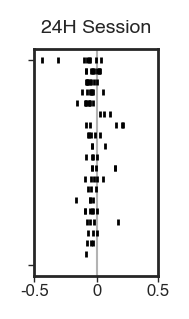

In [71]:
fig = plt.figure(figsize=(0.8, 1.5), dpi=200)
ax = fig.add_subplot(111)

expt = grp[5]._get_session('control_24h')
print len(expt.rois())
spikes = expt.spikes(binary=True)[0, ...]

abspos = ba.absolutePosition(expt.find('trial'))
pos = ((abspos * 100).astype(int) / 100.) % 1 # relative position rounded to two decimals
laps = abspos.astype(int)
running = expt.velocity()[0] > 1

# shift = (50-int(expt._get_stim_positions(units='normalized')[0]))/100.

ax.axvline(0.5, color='0.7', ls='-', lw=0.75)

spike_idx = np.where(spikes)[0]
for spike_i in spike_idx:
    if not running[spike_i]:
        continue
    lap = int(abspos[spike_i])
    if lap == 0:
        continue
    pos = (abspos[spike_i] + shift) % 1
    
    ax.plot(pos, -lap, marker='|', color='k')

ax.set_xticks([0, .50, .99])
ax.set_xticklabels([-0.5, 0, 0.5], rotation=0)
# ax.set_yticks([-1, -lap])
# ax.set_yticklabels([1, lap])
ax.set_yticks([-1, -20])
ax.set_yticklabels([])
ax.set_ylim([-21, 0])
# ax.set_ylabel('Lap')
# ax.set_xlabel('Normalized Position')
ax.set_title('24H Session')
fig.savefig(savedir + 'example_raster_ms152_24h.svg')

1


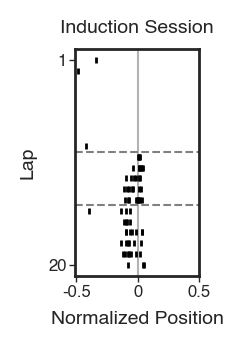

In [69]:
fig = plt.figure(figsize=(0.8, 1.5), dpi=200)
ax = fig.add_subplot(111)

expt = grp[5]
print len(expt.rois())
spikes = expt.spikes(binary=True)[0, ...]

abspos = ba.absolutePosition(expt.find('trial'))
pos = ((abspos * 100).astype(int) / 100.) % 1 # relative position rounded to two decimals
laps = abspos.astype(int)
running = expt.velocity()[0] > 1

shift = (50-int(expt._get_stim_positions(units='normalized')[0]))/100.

spike_idx = np.where(spikes)[0]

ax.axvline(0.5, color='0.7', ls='-', lw=0.75)
ax.axhline(-9.5, color='0.5', ls='--', lw=0.75)
ax.axhline(-14.5, color='0.5', ls='--', lw=0.75)



for spike_i in spike_idx:
    if not running[spike_i]:
        continue
    lap = int(abspos[spike_i])
    if (lap == 0) or (lap >20):
        continue
    pos = (abspos[spike_i] + shift) % 1
    
    ax.plot(pos, -lap, marker='|', color='k')

ax.set_xticks([0, .50, .99])
ax.set_xticklabels([-0.5, 0, 0.5], rotation=0)
ax.set_yticks([-1, -20])
ax.set_yticklabels([1, 20])
ax.set_ylim([-21, 0])
ax.set_ylabel('Lap')
ax.set_xlabel('Normalized Position')
ax.set_title('Induction Session')
fig.savefig(savedir + 'example_raster_ms152.svg')

2


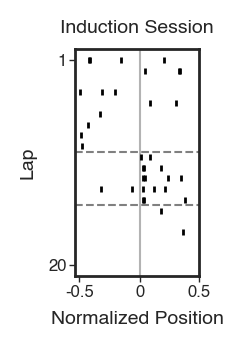

In [14]:
fig = plt.figure(figsize=(0.8, 1.5), dpi=200)
ax = fig.add_subplot(111)

expt = grp[-3]
print len(expt.rois())
spikes = expt.spikes(binary=True)[1, ...]

abspos = ba.absolutePosition(expt.find('trial'))
pos = ((abspos * 100).astype(int) / 100.) % 1 # relative position rounded to two decimals
laps = abspos.astype(int)
running = expt.velocity()[0] > 1

shift = (50-int(expt._get_stim_positions(units='normalized')[0]))/100.

spike_idx = np.where(spikes)[0]

ax.axvline(0.5, color='0.7', ls='-', lw=0.75)
ax.axhline(-9.5, color='0.5', ls='--', lw=0.75)
ax.axhline(-14.5, color='0.5', ls='--', lw=0.75)



for spike_i in spike_idx:
    if not running[spike_i]:
        continue
    lap = int(abspos[spike_i])
    if (lap == 0) or (lap >20):
        continue
    pos = (abspos[spike_i] + shift) % 1
    
    ax.plot(pos, -lap, marker='|', color='k')

ax.set_xticks([0, .50, .99])
ax.set_xticklabels([-0.5, 0, 0.5], rotation=0)
ax.set_yticks([-1, -20])
ax.set_yticklabels([1, 20])
ax.set_ylim([-21, 0])
ax.set_ylabel('Lap')
ax.set_xlabel('Normalized Position')
ax.set_title('Induction Session')
fig.savefig(savedir + 'example_raster_ms151_failure.svg')

2


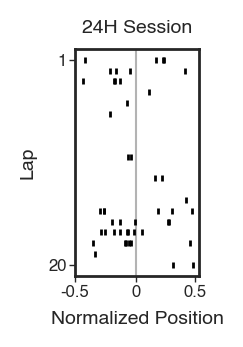

In [94]:
fig = plt.figure(figsize=(0.8, 1.5), dpi=200)
ax = fig.add_subplot(111)

expt = grp[-3]._get_session('control_24h')
print len(expt.rois())
spikes = expt.spikes(binary=True)[1, ...]

abspos = ba.absolutePosition(expt.find('trial'))
pos = ((abspos * 100).astype(int) / 100.) % 1 # relative position rounded to two decimals
laps = abspos.astype(int)
running = expt.velocity()[0] > 1

shift = (50-int(grp[-3]._get_stim_positions(units='normalized')[0]))/100.

spike_idx = np.where(spikes)[0]

ax.axvline(0.5, color='0.7', ls='-', lw=0.75)
# ax.axhline(-9.5, color='0.5', ls='--', lw=0.75)
# ax.axhline(-14.5, color='0.5', ls='--', lw=0.75)



for spike_i in spike_idx:
    if not running[spike_i]:
        continue
    lap = int(abspos[spike_i])
    if (lap == 0) or (lap >20):
        continue
    pos = (abspos[spike_i] + shift) % 1
    
    ax.plot(pos, -lap, marker='|', color='k')

ax.set_xticks([0, .50, .99])
ax.set_xticklabels([-0.5, 0, 0.5], rotation=0)
ax.set_yticks([-1, -20])
ax.set_yticklabels([1, 20])
ax.set_ylim([-21, 0])
ax.set_ylabel('Lap')
ax.set_xlabel('Normalized Position')
ax.set_title('24H Session')
fig.savefig(savedir + 'example_raster_ms151_failure_24h.svg')

### Average Heatmap

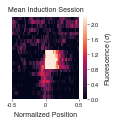

In [66]:
fig = plt.figure(figsize=(1.5, 1.5))
ax = fig.add_subplot(111)
sns.heatmap(avg_heatmap[1:23, :], ax=ax, rasterized=True, vmin=0,
            vmax=np.nanpercentile(avg_heatmap, 97.5),
            cbar_kws={'label': r'Fluorescence ($\sigma$)'})
clean(ax, full=True)
ax.set_title('Mean Induction Session')
ax.set_xlabel('Normalized Position')

ax.set_xticks([0, 50, 100])
ax.set_xticklabels(['-0.5', '0', '0.5'])

fig.savefig(savedir + 'average_heatmap_short.svg')

In [37]:
for expt in grp:
    rois = expt.rois()
    for roi in rois:
        if ind_filter(roi):
            inded = True
        else:
            inded = False
        print expt.trial_id, roi.label, inded

24596 soma-5516504501953315203 True
24761 soma1-7930187571648236399 True
24761 soma0-7930187571648236399 True
24786 soma-7040697630148030621 True
24801 soma-4040691630118030520 True
25079 soma1-1040656630144030889 True
25079 soma0-1040656630144030889 False
25080 soma-959363370226970299 True
25081 soma-2959389370188969880 False


[Text(0.5,0,'-0.5'), Text(10.5,0,'0'), Text(20.5,0,'0.5')]

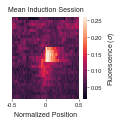

In [72]:
# Only include induced cells
fig = plt.figure(figsize=(1.5, 1.5))
# fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

success_heatmaps = [x for i, x in enumerate(heatmaps) if i not in [6, 8]]

shortest = min([len(x) for x in success_heatmaps]) - 1
avg_success_heatmap = np.zeros((shortest, 100))
for hm in success_heatmaps:
    temp = hm[:shortest, :]
    temp[temp > np.nanpercentile(temp, 97.5)] = np.nanpercentile(temp, 97.5)
    temp = (temp - np.nanmin(temp)) / (np.nanmax(temp) - np.nanmin(temp))
    avg_success_heatmap += np.nan_to_num(temp)
avg_success_heatmap /= float(len(avg_success_heatmap))

sns.heatmap(avg_success_heatmap, ax=ax, rasterized=True,
            cbar_kws={'label': r'Fluorescence ($\sigma$)'})
clean(ax, full=True)
ax.set_title('Mean Induction Session')
ax.set_xlabel('Normalized Position')

ax.set_xticks([0, 50, 100])
ax.set_xticklabels(['-0.5', '0', '0.5'])

# fig.savefig(savedir + 'average_heatmap_induced_only.svg')

### Average Tuning by Session

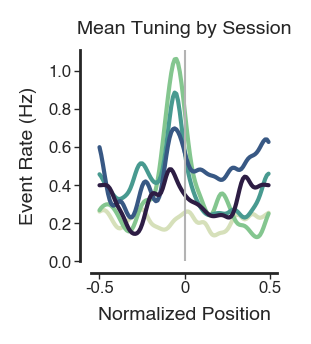

In [92]:
fig = plt.figure(figsize=(1.2, 1.4), dpi=200)
ax = fig.add_subplot(111)
colors = sns.cubehelix_palette(5, start=0.5, rot=-0.75, hue=1)
for tc, color, in zip(tcs, colors):
    ax.plot(tc, color=color)
clean(ax, full=False, offset=4)
ax.set_ylim([0, ax.get_ylim()[1]])
ax.axvline(50, color='0.7', ls='-', lw=0.75)
ax.set_title('Mean Tuning by Session')

ax.set_xlabel('Normalized Position')
ax.set_ylabel('Event Rate (Hz)')

ax.set_xticks([0, 50, 100])
ax.set_xticklabels(['-0.5', '0', '0.5'])

fig.savefig(savedir + 'average_tuning_by_session_yaxis.svg')

[Text(0,0,'-0.5'), Text(0,0,'0'), Text(0,0,'0.5')]

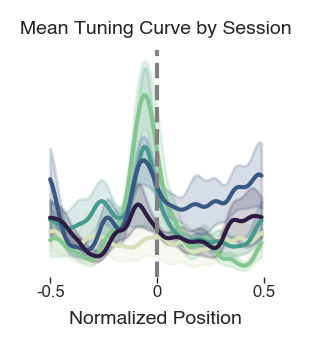

In [62]:
fig = plt.figure(figsize=(1.5, 1.5), dpi=200)
ax = fig.add_subplot(111)
colors = sns.cubehelix_palette(5, start=0.5, rot=-0.75, hue=1)
for tc, std, color, in zip(success_tcs, success_tc_sems, colors):
    ax.plot(tc, color=color)
    ax.fill_between(x=range(len(tc)), y1=tc-std.squeeze(), y2=tc+std.squeeze(), color=color, alpha=0.2)
clean(ax, full=True)
ax.set_ylim([0, ax.get_ylim()[1]])
ax.axvline(50, color='0.5', ls='--')
ax.set_title('Mean Tuning Curve by Session')

ax.set_xlabel('Normalized Position')

ax.set_xticks([0, 50, 100])
ax.set_xticklabels(['-0.5', '0', '0.5'])

In [60]:
diffs, etcs, btcs = sce.tuning_difference(grp)

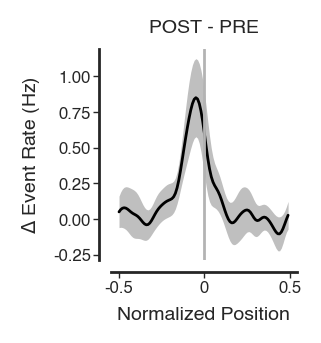

In [93]:
fig = plt.figure(figsize=(1.2, 1.4), dpi=200)
ax = fig.add_subplot(111)

# ax.plot(diffs[0].T)
diffmean = np.nanmean(diffs, axis=0)
diffsem = sem(diffs, axis=0)

ax.plot(diffmean, lw=1, color='k')
ax.fill_between(x=range(0, 100), y1=diffmean-diffsem, y2=diffmean+diffsem, lw=0, color='0.5', alpha=0.5)

clean(ax, full=False, offset=4)
# ax.set_ylim([0, ax.get_ylim()[1]])
ax.axvline(50, color='0.7', ls='-', lw=1)
ax.set_title('POST - PRE')

ax.set_xlabel('Normalized Position')
ax.set_ylabel(r'$\Delta$ Event Rate (Hz)')

ax.set_xticks([0, 50, 100])
ax.set_xticklabels(['-0.5', '0', '0.5'])

fig.savefig(savedir + 'tuning_difference_yaxis.svg')

In [ ]:
fig = plt.figure(figsize=(1.5, 1.5), dpi=200)
ax = fig.add_subplot(111)
colors = sns.cubehelix_palette(5, start=0.5, rot=-0.75, hue=1)



for tc, std, color, in zip(success_tcs, success_tc_sems, colors):
    ax.plot(tc, color=color)
    ax.fill_between(x=range(len(tc)), y1=tc-std.squeeze(), y2=tc+std.squeeze(), color=color, alpha=0.2)
clean(ax, full=True)
ax.set_ylim([0, ax.get_ylim()[1]])
ax.axvline(50, color='0.5', ls='--')
ax.set_title('Mean Tuning Curve by Session')

ax.set_xlabel('Normalized Position')

ax.set_xticks([0, 50, 100])
ax.set_xticklabels(['-0.5', '0', '0.5'])

### Activity Centroid Plots

In [77]:
success_df['expt_id'] = success_df['expt']

In [78]:
merge_df = activity_centroid_df.merge(success_df, on=['expt_id', 'roi', 'session'], how='outer')

In [79]:
merge_df['induced'] = merge_df['induced'].fillna(value=False)

session
24h     44.122096
48h     44.580433
72h     46.373262
Post    27.579429
Pre     59.419340
Name: abs_dist, dtype: float64
session
24h      8.948439
48h     12.458270
72h      8.514212
Post     8.444007
Pre      8.835389
Name: abs_dist, dtype: float64
Pre Ttest_1sampResult(statistic=1.2358640729655428, pvalue=0.25156520177660324)
Post Ttest_1sampResult(statistic=-2.477564510969867, pvalue=0.038256623048294525)
24h Ttest_1sampResult(statistic=-0.48923663094567177, pvalue=0.637805170443553)
48h Ttest_1sampResult(statistic=-0.3146156922383717, pvalue=0.7611022923524522)
72h Ttest_1sampResult(statistic=-0.24978683230487975, pvalue=0.8099239926738802)


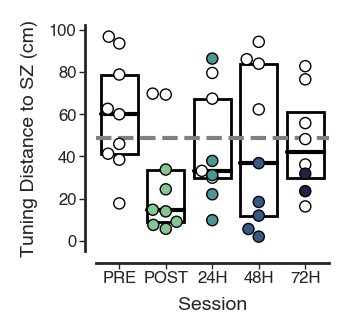

In [89]:
fig = plt.figure(figsize=(1.5, 1.5), dpi=200)
ax = fig.add_subplot(111)

colors = sns.cubehelix_palette(4, start=0.5, rot=-0.75, hue=1, light=1)
colors = [colors[0]] + [[1, 0, 0]] + colors[1:]

session_names = ['Pre', 'Post', '24h', '48h', '72h']
sessions = ['PRE', 'POST', '24H', '48H', '72H']
sns.boxplot(x='session', y='abs_dist', data=activity_centroid_df, 
            order=session_names, showcaps=False,
            showfliers=False, whis=False, ax=ax)
plt.setp(ax.artists, edgecolor='k', facecolor='w', linewidth=1)
plt.setp(ax.lines, color='k')


merge_df = activity_centroid_df.merge(success_df, on=['expt_id', 'roi', 'session'], how='outer')
merge_df['induced'] = merge_df['induced'].fillna(value=False)
sns.swarmplot(x='session', y='abs_dist', data=merge_df.loc[~merge_df['induced']],
              order=session_names, ax=ax, size=4,
              color='w', edgecolor='k', linewidth=0.5, marker='o')
sns.swarmplot(x='session', y='abs_dist', data=merge_df.loc[merge_df['induced']],
              order=session_names, ax=ax, size=4,
              palette=colors, edgecolor='k', linewidth=0.5, marker='o')

ax.axhline(194./4, color='0.5', ls='--')
clean(ax, offset=4)
ax.set_ylim([-5, ax.get_ylim()[1]])
ax.set_ylabel('Tuning Distance to SZ (cm)')
ax.set_xlabel('Session')
ax.set_xticklabels(sessions);

fig.savefig(savedir + 'activity_centroid_plot.svg')

print activity_centroid_df.groupby('session').mean()['abs_dist']
print activity_centroid_df.groupby('session').sem()['abs_dist']

for session in session_names:
    print session, ttest_1samp(activity_centroid_df.loc[activity_centroid_df['session'] == session]['abs_dist'], 194/4.)

### Activity Centroid Shift

31.83991060554504
11.365474782587421
Ttest_1sampResult(statistic=2.801458910834562, pvalue=0.023145729690788604)


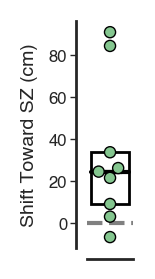

In [87]:
fig = plt.figure(figsize=(.3, 1.5), dpi=200)
ax = fig.add_subplot(111)

shift_df = activity_centroid_df.loc[(activity_centroid_df['session'] == 'Post')].merge(
        activity_centroid_df.loc[(activity_centroid_df['session'] == 'Pre')],
        on=['roi', 'mouse_name'],
        suffixes=['_ind', '_base'])

shift_df['shift'] = shift_df.apply(lambda x: x['abs_dist_base'] - x['abs_dist_ind'], axis=1)
sns.boxplot(y='shift', data=shift_df, showcaps=False,
                showfliers=False, whis=False, ax=ax)
plt.setp(ax.artists, edgecolor='k', facecolor='w', linewidth=1)
plt.setp(ax.lines, color='k')
sns.swarmplot(y='shift', hue='mouse_name', data=shift_df, ax=ax, size=4,
              color=colors[1], edgecolor='k', linewidth=0.5)
med = shift_df.median()['shift']
ax.plot([-0.25, 0.25], [med, med], color='k')
ax.plot([-0.5, 0.5], [0, 0], color='0.5', ls='--')

clean(ax, offset=4)
ax.set_xticks([])
ax.set_ylabel('Shift Toward SZ (cm)')

fig.savefig(savedir + 'activity_centroid_shift.svg', bbox_inches='tight')

print shift_df.mean()['shift']
print shift_df.sem()['shift']
print ttest_1samp(shift_df['shift'], 0)

### Fraction PFs

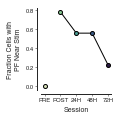

In [168]:
fig = plt.figure(figsize=(1.25, 1.5))
ax = fig.add_subplot(111)

sessions = ['PRE', 'POST', '24H', '48H', '72H']

ax.plot([0], pct_success['pct'][0], mec='k', color=colors[0], marker='o', ms=4)
vals = pct_success['pct'].values[1:]
ax.plot(range(1, len(sessions)), vals, 'k-', lw=1)
for i, val in enumerate(vals):
    ax.plot(i + 1, val, marker='o',
            ms=4, mec='k', color=colors[i+1])
ax.set_xticks(range(len(sessions)))
ax.set_xticklabels(sessions)
clean(ax, offset=4)
ax.set_ylabel('Fraction Cells with\nPF Near Stim')
ax.set_xlabel('Session')

fig.savefig(savedir + 'fraction_pfs.svg')

### Left Shift

-10.878571428571435
2.155829780111669
Ttest_1sampResult(statistic=-5.046117986183464, pvalue=0.002342612383160176)


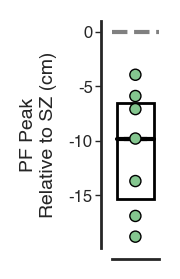

In [88]:
# Left Shift
fig = plt.figure(figsize=(.3, 1.5), dpi=200)
ax = fig.add_subplot(111)
sns.boxplot(y='shift', data=left_shifts, showcaps=False,
                showfliers=False, whis=False, ax=ax)
plt.setp(ax.artists, edgecolor='k', facecolor='w', linewidth=1)
plt.setp(ax.lines, color='k')
sns.swarmplot(y='shift', hue='mouse', data=left_shifts, ax=ax, size=4,
              color=colors[1], edgecolor='k', linewidth=0.5)
med = left_shifts.median()['shift']
ax.plot([-0.25, 0.25], [med, med], color='k')
ax.plot([-0.5, 0.5], [0, 0], color='0.5', ls='--')
clean(ax, offset=4)
ax.set_xticks([])

ax.set_ylabel('PF Peak\nRelative to SZ (cm)')

fig.savefig(savedir + 'peak_left_shift.svg', bbox_inches='tight')

print left_shifts.mean()['shift']
print left_shifts.sem()['shift']
print ttest_1samp(left_shifts['shift'], 0)

### Velocity vs. Width

(0.943096907731094, 0.0014385481841046447)


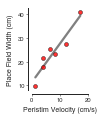

In [9]:
fig = plt.figure(figsize=(1, 1.5))
ax = fig.add_subplot(111)
scatter_kws = {'s': 16, 'color': colors[1], 'edgecolors': 'k', 'zorder': 1000, 'linewidths':'0.5'}
line_kws = {'color': '0.5'}
sns.regplot(y='width', x='vel', data=vel_width, ci=0, truncate=True,
            scatter_kws=scatter_kws, line_kws=line_kws)

clean(ax, offset=4)
ax.set_xlim([0, 20])
ax.set_xlabel('Peristim Velocity (cm/s)')
ax.set_ylabel('Place Field Width (cm)')

# fig.savefig(savedir + 'velocity_width.svg')

print pearsonr(vel_width['width'], vel_width['vel'])

# Analysis functions for data saving

In [4]:
def activity_centroid_plots(grp):

    full_sessions = ['control_induction', 'control_24h', 'control_48h', 'control_72h']
    session_names = ['Pre', 'Post', '24h', '48h', '72h']

    # Plots comparing activity centroid distance to stim zone for
    # a set of sessions - for now has to be all control or all cno

    # First calculate for baseline laps
    # Have to do this manually because these tcs arent saved anywhere
    # only those post-induction are
    df = sce.baseline_activity_centroid_distance(grp)
    df['session'] = session_names[0]

    df = df.drop(columns=['tc', 'stim_loc'])

    stim_session = 'control_induction'
    for session, session_name in zip(full_sessions, session_names[1:]):

        sess_grp = [x._get_session(session) for x in grp]
        sess_grp = pcExperimentGroup(sess_grp, **grp.args)

        sess_df = ia.activity_centroid_distance(sess_grp, stim_session=stim_session)
        sess_df['session'] = session_name

        df = pd.concat([df, sess_df])
        
    return df

In [11]:
def average_heatmap(grp, signal='dff', z_score=False):

    heatmaps = ia.grp_heatmap(grp, signal=signal, z_score=z_score)

    shortest = min([len(x) for x in heatmaps]) - 1
    avg_heatmap = np.zeros((shortest, 100))
    for hm in heatmaps:
        avg_heatmap += np.nan_to_num(hm[:shortest, :])
    avg_heatmap /= float(len(heatmaps))

    # Calc COMs
    post_laps = np.arange(10, avg_heatmap.shape[0])
    # coms = [calc_activity_centroid(avg_heatmap[i, :]) for i in post_laps]
    coms = []
    for lap in post_laps:
        lap_coms = [sce.calc_activity_centroid(np.nan_to_num(hm[lap, :])) for hm in heatmaps]
        coms.append(np.nanmedian(lap_coms))


    return avg_heatmap, heatmaps, coms

In [55]:
from lab.analysis.identify_place_fields import smooth_tuning_curves
from scipy.stats import sem
def average_tuning_curves(grp, roi_filter=None):

    full_sessions = ['control_induction', 'control_24h', 'control_48h', 'control_72h']
    session_names = ['Pre', 'Post', '24h', '48h', '72h']
    tcs = []
    pre_tcs = []
    stds = []
    heatmaps = ia.grp_heatmap(grp, roi_filter=roi_filter)

    roi_count = 0
    for expt in grp:
        stim_loc = expt._get_stim_positions(units='normalized')[0]
        shift_back = 50 - int(stim_loc)

        nrois = len(expt.rois(roi_filter=roi_filter))
        for i in xrange(nrois):
            pre_tc = np.roll(np.nanmean(heatmaps[roi_count][:10, :], axis=0), shift_back)
            pre_tcs.append(smooth_tuning_curves([pre_tc], smooth_length=3, axis=1, nan_norm=False))
            roi_count += 1

    tcs.append(np.nanmean(pre_tcs, axis=0).squeeze())
    print len(pre_tcs)
    stds.append(sem(pre_tcs, axis=0))

    for session in full_sessions:
        sess_tcs = []
        sess_grp = [x._get_session(session) for x in grp]
        sess_grp = pcExperimentGroup(sess_grp, **grp.args)

        data = sess_grp.data(roi_filter=roi_filter)
        for expt in sess_grp:
            stim_loc = expt._get_session('control_induction')._get_stim_positions(units='normalized')[0]
            shift_back = 50 - int(stim_loc)
            sess_tcs.extend(np.roll(data[expt], shift_back, axis=1))
        tcs.append(np.nanmean(sess_tcs, axis=0) / expt.frame_period())
        print len(sess_tcs)
        stds.append(sem(sess_tcs / expt.frame_period(), axis=0))

    return tcs, stds

In [5]:
activity_centroid_df = activity_centroid_plots(grp)
activity_centroid_df.to_pickle('/home/sebi/data/induction/fig1/activity_centroid_df.pkl')

In [12]:
avg_heatmap, heatmaps, coms = average_heatmap(grp, z_score=True)
with open('/home/sebi/data/induction/fig1/heatmaps.pkl', 'wb') as fw:
    pkl.dump([avg_heatmap, heatmaps, coms], fw)

In [16]:
vel_width = sce.velocity_vs_width(grp)
vel_width.to_pickle('/home/sebi/data/induction/fig1/vel_width.pkl')

In [4]:
vel_width = pd.read_pickle('/home/sebi/data/induction/fig1/vel_width.pkl')

In [56]:
success_tcs, success_tc_sems = average_tuning_curves(grp, ind_filter)

7
7
7
7
7


In [20]:
tcs = average_tuning_curves(grp)
with open('/home/sebi/data/induction/fig1/tcs.pkl', 'wb') as fw:
    pkl.dump(tcs, fw)

In [84]:
with open('/home/sebi/data/induction/fig1/tcs.pkl', 'rb') as fp:
    tcs = pkl.load(fp)

In [21]:
stim_filter = lambda x: True
ind_filter = filters.grp_induction_filter(grp, stim_filter=stim_filter, overwrite=False)
left_shifts = sce.left_shift(grp, ind_filter)
left_shifts.to_pickle('/home/sebi/data/induction/fig1/left_shifts.pkl')

In [59]:
pct_success = sce.percent_success_by_day(grp)
pct_success.to_pickle(data_dir + 'pct_success.pkl')

In [33]:
success_df = sce.success_by_day(grp)